#Import Libraries

In [1]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 8

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Import Data

In [26]:
coc = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [27]:
coc.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [28]:
quarter=['Q1','Q2','Q3','Q4']
n=coc['Quarter'][0]
n[0:2]

coc['quarter']=0

In [29]:
coc.shape

(42, 3)

In [41]:
for i in range(42):
    n=coc['Quarter'][i]
    coc['quarter'][i]=n[0:2]

In [42]:
dummy=pd.DataFrame(pd.get_dummies(coc['quarter']))

In [43]:
coco=pd.concat((coc,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [44]:
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales

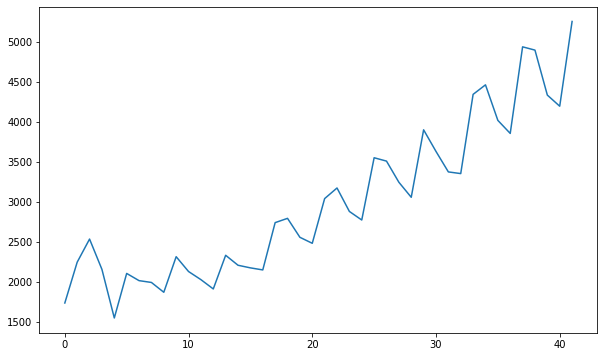

In [71]:
train= coco.head(38)
test=coco.tail(4)
coco.Sales.plot()

#Linear Model

In [46]:
import statsmodels.formula.api as smf
linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
rmselin

421.17878760022745

#Quadractic Model

In [47]:
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad

475.56183518315606

#Exponential model

In [48]:
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

466.2479731067161

#Additive seasonality

In [49]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd

1860.0238154547274

#Additive seasonality with linear trend

In [50]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

464.98290239822427

#Additive seasonality with quadratic trend

In [51]:
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad

301.73800719349674

#Multiplicative seasonality

In [52]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

1963.3896400779668

#Multiplicative seasonality with linear trend

In [53]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

225.52439049827947

#Multiplicative seasonality with Quadratic trend

In [54]:
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

581.8457187963156

#RMSE values

In [55]:
data={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
data

{'Model': 0    rmse_mul_quad
 1          rmseadd
 2    rmseaddlinear
 3      rmseaddquad
 4         rmseexpo
 5          rmselin
 6          rmsemul
 7        rmsemulin
 8         rmsequad
 dtype: object, 'Values': 0     581.845719
 1    1860.023815
 2     464.982902
 3     301.738007
 4     466.247973
 5     421.178788
 6    1963.389640
 7     225.524390
 8     475.561835
 dtype: float64}

In [56]:
Rmse=pd.DataFrame(data)
Rmse

,Model,Values
0,rmse_mul_quad,581.845719
1,rmseadd,1860.023815
2,rmseaddlinear,464.982902
3,rmseaddquad,301.738007
4,rmseexpo,466.247973
5,rmselin,421.178788
6,rmsemul,1963.389640
7,rmsemulin,225.524390
8,rmsequad,475.561835


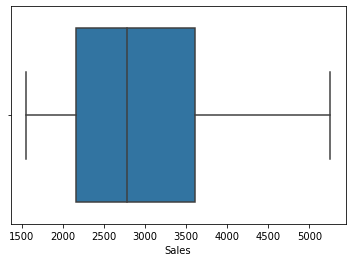

In [57]:
sns.boxplot("Sales",data=coc)

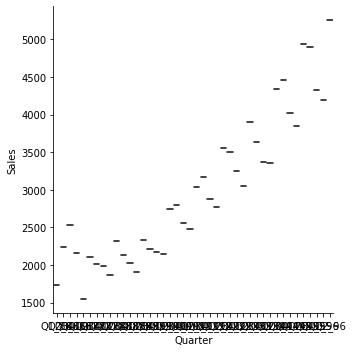

In [72]:
sns.factorplot("Quarter","Sales",data=coc,kind="box")

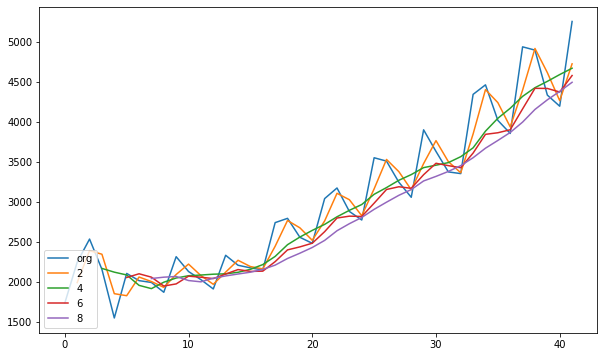

In [73]:
coc.Sales.plot(label="org")
for i in range(2,10,2):
    coc["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

In [60]:
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models

#ACF and PACF plots for original data

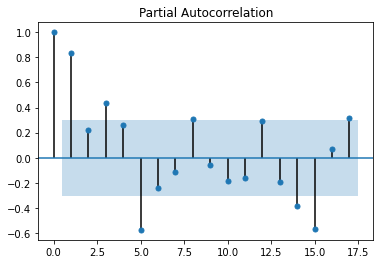

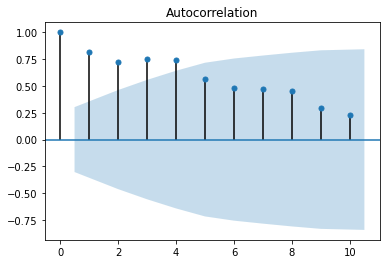

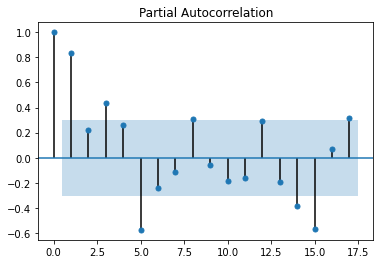

In [61]:
tsa_plots.plot_acf(coc.Sales,lags=10)
tsa_plots.plot_pacf(coc.Sales)

In [62]:
Train = coc.head(48)
Test =coc.tail(12)

MAPE Values

In [63]:
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

Simple Exponential Method

In [64]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

9.765071349339516

Holt method 

In [65]:
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales)

9.78507954478971

Holts winter exponential smoothing with additive seasonality and additive trend

In [66]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

3.1086442709947097

Holts winter exponential smoothing with multiplicative seasonality and additive trend

In [67]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales)

2.359174896062602

#Visualizing Multiple Data

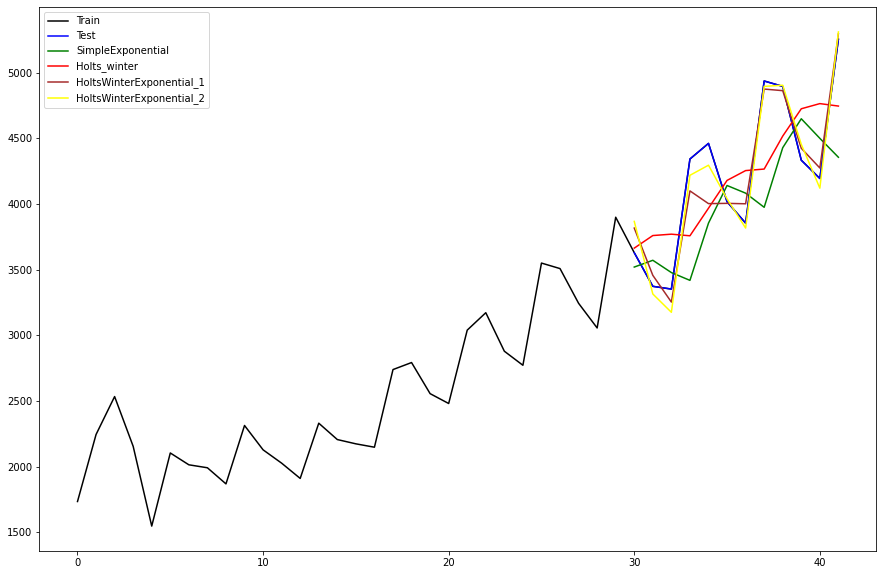

In [75]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 10

plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')